# Compute bouyancy gradient and Q_EBF for CTD stations

In [9]:
import csv
import gsw
import numpy as np
import pandas as pd
import pycnv
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from cmocean import cm as cmo

Open weather data

In [10]:
df_wind = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_weather.csv")
df_pos = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_position.csv")

df_wind['ts'] = pd.to_datetime(df_wind['ts']).dt.round('1s')
df_pos['ts'] = pd.to_datetime(df_pos['ts']).dt.round('1s')

df = pd.merge(df_pos, df_wind, on='ts', how='inner')

df = df.rename(columns={'ts': 'Time'})
df = df.rename(columns={'longitude': 'Longitude'})
df = df.rename(columns={'latitude': 'Latitude'})

In [11]:
df['datetime'] = pd.to_datetime(df['Time'])
df = df.sort_values('datetime')


from scipy.spatial import cKDTree
import numpy as np

# Create arrays of coordinates: (Latitude, Longitude) → convert to radians for distance
wind_coords = np.radians(df[['Latitude', 'Longitude']].to_numpy())
ferry_coords = np.radians(df[['Latitude', 'Longitude']].to_numpy())

# Build tree from wind positions
tree = cKDTree(wind_coords)

# Query nearest neighbor in wind data for each ferrybox point
dist_rad, idx = tree.query(ferry_coords, k=1)

# Convert radians to meters (~Earth radius)
earth_radius = 6371000  # meters
dist_m = dist_rad * earth_radius


In [13]:
print(df.columns)

Index(['Time', 'Latitude', 'Longitude', 'gndspeed', 'gndcourse', 'gps_quality',
       'nbused', 'hdop', 'airtemp', 'humidity', 'airpressure', 'windspeed',
       'winddir', 'datetime'],
      dtype='object')


In [14]:
# Get windstress

# ── 2.  vectorised air-density ρ_a(T, p, RH) ───────────────────────────
T   = df['airtemp'].to_numpy(float)         # °C
P   = df['airpressure'].to_numpy(float) * 100    # hPa → Pa
RH  = df['humidity'].to_numpy(float) / 100     # %

Rd, Rv = 287.05, 461.5
es = 611.2 * np.exp((17.67 * T) / (T + 243.5))   # Pa (sat. vapour press.)
e  = RH * es                                     # Pa (actual vapour press.)
rho_air = (P - e) / (Rd * (T + 273.15)) + e / (Rv * (T + 273.15))

# ── 3.  wind-vector components (u, v) from speed + “from” direction ────
U     = df['windspeed'].to_numpy(float)          # m s⁻¹
theta = np.deg2rad(df['winddir'].to_numpy(float))

u = -U * np.sin(theta)      # eastward (+ = toward east)
v = -U * np.cos(theta)      # northward (+ = toward north)

# ── 4.  constant drag coefficient & wind-stress components ─────────────
Cd   = 1.5e-3                                    # dimensionless
tau  = rho_air * Cd * U**2                       # magnitude  (N m⁻²)
tau_x = rho_air * Cd * U * u                     # eastward stress
tau_y = rho_air * Cd * U * v                     # northward stress

# store in DataFrame
df['tau']   = tau
df['tau_x'] = tau_x
df['tau_y'] = tau_y

# ── 5.  quick sanity print ─────────────────────────────────────────────
print(df[['Time', 'Latitude', 'Longitude', 'tau', 'tau_x', 'tau_y']].head())

                 Time   Latitude  Longitude       tau     tau_x     tau_y
0 2025-05-06 07:00:00  57.686355  11.893357  0.021691 -0.004510 -0.021217
1 2025-05-06 07:01:00  57.686355  11.893356  0.020434 -0.004597 -0.019910
2 2025-05-06 07:02:00  57.686355  11.893358  0.018033  0.008466 -0.015922
3 2025-05-06 07:03:00  57.686355  11.893356  0.011727 -0.001429 -0.011640
4 2025-05-06 07:04:00  57.686363  11.893342  0.027085  0.001889 -0.027019


# Day 1

INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_01_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_02_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_03_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_04_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


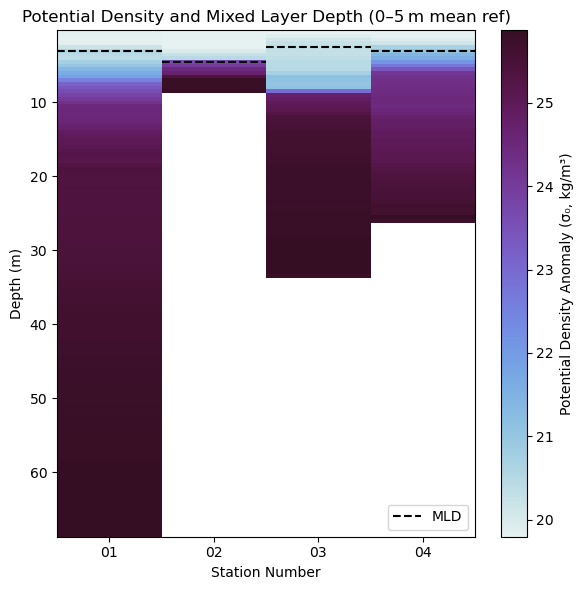

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
import gsw
import cmocean

# Folder and filenames
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_01_avg.cnv',
    'CTD_02_avg.cnv',
    'CTD_03_avg.cnv',
    'CTD_04_avg.cnv'
]

# Initialize storage
all_depths = []
all_sigma0 = []
mld_list = []

# Parameters
delta_sigma = 0.03  # density threshold
ref_depth_limit = 5  # upper depth limit (m) for mean reference

# Loop through files
for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))

    p = np.array(cnv.data['p'])
    t = np.array(cnv.data['t090C'])
    sp = np.array(cnv.data['sal00'])
    lat = cnv.lat
    lon = cnv.lon
    depth = np.array(cnv.data['depSM'])

    # Compute Absolute Salinity and Conservative Temperature
    SA = gsw.SA_from_SP(sp, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)

    # Compute sigma0
    sigma0 = gsw.sigma0(SA, CT)

    # Use the average σ₀ in the top X meters (0–5 m) as reference
    shallow_mask = depth <= ref_depth_limit
    if np.any(shallow_mask):
        sigma0_ref = np.nanmean(sigma0[shallow_mask])
    else:
        sigma0_ref = sigma0[0]  # fallback if no shallow values

    # Find first depth where Δσ₀ > threshold
    mld = np.nan
    for d, s in zip(depth, sigma0):
        if s - sigma0_ref > delta_sigma:
            mld = d
            break

    mld_list.append(mld)
    all_depths.append(depth)
    all_sigma0.append(sigma0)

# Plotting
plt.figure(figsize=(6, 6))

for i, (depth, sigma, mld) in enumerate(zip(all_depths, all_sigma0, mld_list)):
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])
    x_edges = [i - 0.5, i + 0.5]
    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)
    S = sigma.reshape(-1, 1)

    # Plot sigma0
    pcm = plt.pcolormesh(X_grid, Y_grid, S, shading='auto', cmap=cmocean.cm.dense,
                         vmin=np.nanmin(sigma), vmax=np.nanmax(sigma))

    # Plot MLD as line
    if not np.isnan(mld):
        plt.hlines(mld, i - 0.5, i + 0.5, color='black', linestyle='--', linewidth=1.5,
                   label='MLD' if i == 0 else "")

# Final touches
plt.gca().invert_yaxis()
plt.colorbar(pcm, label='Potential Density Anomaly (σ₀, kg/m³)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title(f'Potential Density and Mixed Layer Depth (0–{ref_depth_limit} m mean ref)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Day 2

INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_05_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_06_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_07_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_08_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_09_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneD

Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


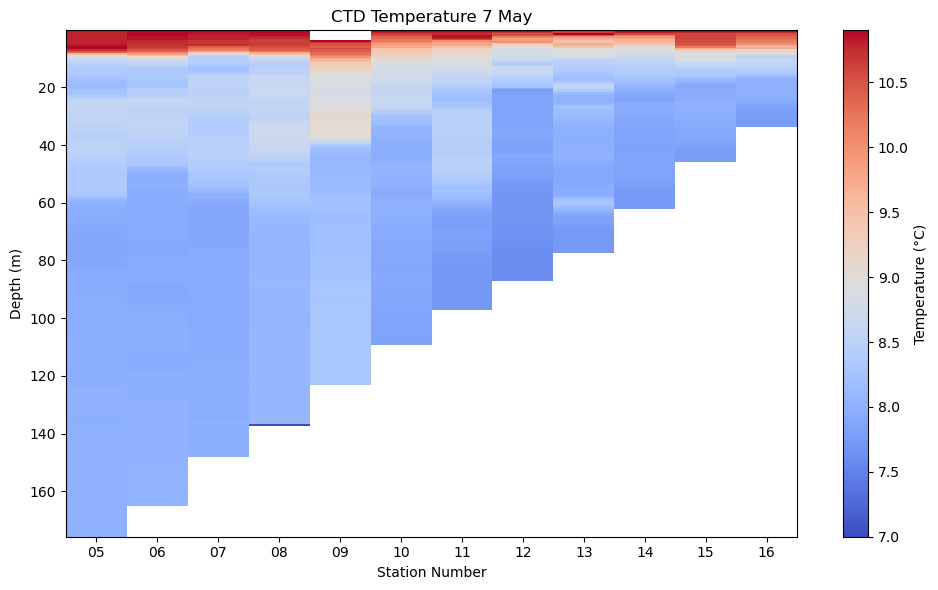

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
from cmocean import cm as cmo

# Folder and filenames
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_05_avg.cnv',
    'CTD_06_avg.cnv',
    'CTD_07_avg.cnv',
    'CTD_08_avg.cnv',
    'CTD_09_avg.cnv',
    'CTD_10_avg.cnv',
    'CTD_11_avg.cnv',
    'CTD_12_avg.cnv',
    'CTD_13_avg.cnv',
    'CTD_14_avg.cnv',
    'CTD_15_avg.cnv',
    'CTD_16_avg.cnv'
]

all_depths = []
all_temps = []

for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))
    all_depths.append(np.array(cnv.data['depSM']))
    all_temps.append(np.array(cnv.data['t090C']))

# Plot
plt.figure(figsize=(10, 6))

for i, (depth, temp) in enumerate(zip(all_depths, all_temps)):
    # Compute edges for depth
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])

    x_edges = [i - 0.5, i + 0.5]

    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)

    # Expand temp to match (M-1, N-1) = (len(depth), 1)
    T = temp.reshape(-1, 1)

    plt.pcolormesh(X_grid, Y_grid, T, shading='auto', cmap='coolwarm', vmin=7)

# Finalize
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature (°C)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title('CTD Temperature 7 May')
plt.tight_layout()
plt.show()


INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_05_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_06_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_07_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_08_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_09_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneD

Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date


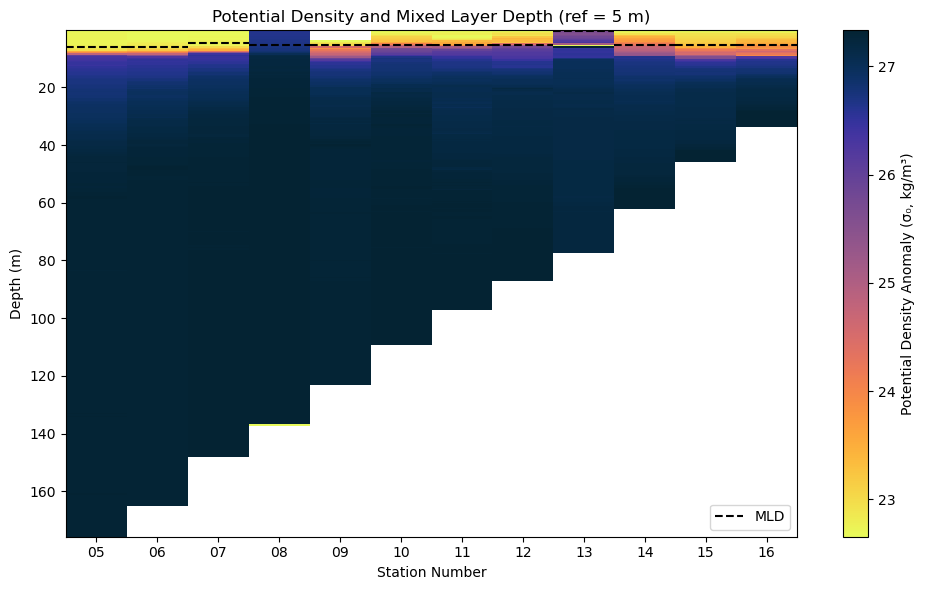

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
import gsw
from cmocean import cm as cmo  # <- added import for colormap

# Folder and filenames
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = [
    'CTD_05_avg.cnv',
    'CTD_06_avg.cnv',
    'CTD_07_avg.cnv',
    'CTD_08_avg.cnv',
    'CTD_09_avg.cnv',
    'CTD_10_avg.cnv',
    'CTD_11_avg.cnv',
    'CTD_12_avg.cnv',
    'CTD_13_avg.cnv',
    'CTD_14_avg.cnv',
    'CTD_15_avg.cnv',
    'CTD_16_avg.cnv'
]

# Set reference depth
ref_depth = 5  # meters

all_depths = []
all_sigma0 = []
mld_list = []

for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))

    p = np.array(cnv.data['p'])
    t = np.array(cnv.data['t090C'])
    sp = np.array(cnv.data['sal00'])
    lat = cnv.lat
    lon = cnv.lon
    depth = np.array(cnv.data['depSM'])

    # Compute SA and CT
    SA = gsw.SA_from_SP(sp, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)

    # Compute sigma0
    sigma0 = gsw.sigma0(SA, CT)

    # --- Reference density at fixed depth (10 m) ---
    try:
        sigma0_ref = np.interp(ref_depth, depth, sigma0)
    except Exception:
        sigma0_ref = np.nan

    # Mixed layer depth threshold method
    mld = np.nan
    for d, s in zip(depth, sigma0):
        if s - sigma0_ref > 0.03:
            mld = d
            break
    mld_list.append(mld)

    all_depths.append(depth)
    all_sigma0.append(sigma0)

# --- Plot ---
plt.figure(figsize=(10, 6))

for i, (depth, sigma, mld) in enumerate(zip(all_depths, all_sigma0, mld_list)):
    if len(depth) < 2:
        continue  # Skip if too few points for edges

    # Compute edges
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])
    x_edges = [i - 0.5, i + 0.5]
    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)
    S = sigma.reshape(-1, 1)

    # Plot sigma0
    pcm = plt.pcolormesh(X_grid, Y_grid, S, shading='auto', cmap=cmo.thermal_r,
                         vmin=np.nanmin(sigma), vmax=np.nanmax(sigma))

    # Plot MLD
    if not np.isnan(mld):
        plt.hlines(mld, i - 0.5, i + 0.5, color='black', linewidth=1.5, linestyle='--',
                   label='MLD' if i == 0 else "")

# Finalize
plt.gca().invert_yaxis()
plt.colorbar(pcm, label='Potential Density Anomaly (σ₀, kg/m³)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title(f'Potential Density and Mixed Layer Depth (ref = {ref_depth} m)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Day 3

INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_17_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\CTD_18_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Date
Computing date


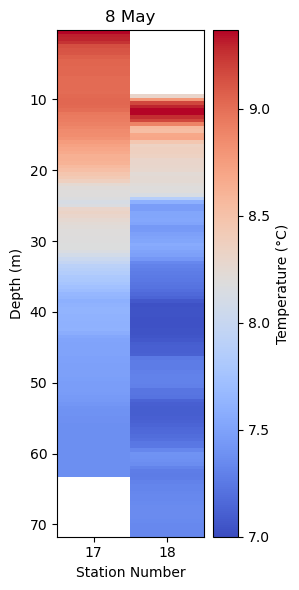

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pycnv
import os
from cmocean import cm as cmo

# Load data
data_folder = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data'
fnames = ['CTD_17_avg.cnv', 'CTD_18_avg.cnv']

all_depths = []
all_temps = []

for fname in fnames:
    cnv = pycnv.pycnv(os.path.join(data_folder, fname))
    all_depths.append(np.array(cnv.data['depSM']))
    all_temps.append(np.array(cnv.data['t090C']))

# Plot
plt.figure(figsize=(3, 6))

for i, (depth, temp) in enumerate(zip(all_depths, all_temps)):
    # Compute edges for depth
    depth_edges = np.concatenate([
        [depth[0] - (depth[1] - depth[0]) / 2],
        (depth[1:] + depth[:-1]) / 2,
        [depth[-1] + (depth[-1] - depth[-2]) / 2]
    ])

    x_edges = [i - 0.5, i + 0.5]

    X_grid, Y_grid = np.meshgrid(x_edges, depth_edges)

    # Expand temp to match (M-1, N-1) = (len(depth), 1)
    T = temp.reshape(-1, 1)

    plt.pcolormesh(X_grid, Y_grid, T, shading='auto', cmap='coolwarm', vmin=7)

# Finalize
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature (°C)')
plt.xticks(np.arange(len(fnames)), [f.split('_')[1] for f in fnames])
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.title('8 May')
plt.tight_layout()
plt.show()


In [ ]:
for i, depth in enumerate(all_depths):
    print(f"{fnames[i]} max depth: {np.nanmax(depth):.1f} m")


CTD_17_avg.cnv max depth: 63.0 m
CTD_18_avg.cnv max depth: 71.5 m
